# Dataset Setup

authors: Bolzonello Enrico, Carlesso Daniel, Zadro Michele

In [1]:
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import warnings
from toolbox import connect_poi
import rtree
import os
import numpy as np
import pandas as pd

%matplotlib inline
ox.__version__

warnings.filterwarnings('ignore')

## Padova Graph

In [2]:
PLACE_NAME = "Padova, Veneto, Italy"

First we need the Padua street network, which we get from OpenStreetMap thanks to the Python library OSMnx

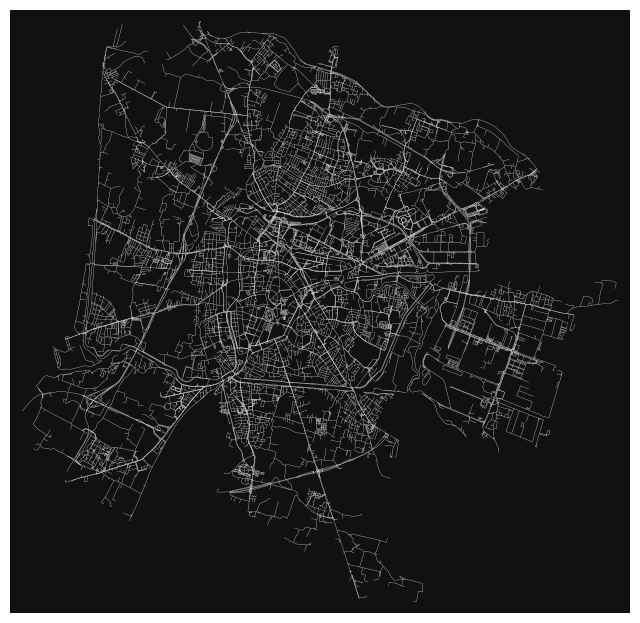

In [3]:
G_padova = ox.graph_from_place(PLACE_NAME, network_type="walk", simplify=True)
G_padova = ox.get_undirected(G_padova)
fig, ax = ox.plot_graph(G_padova, node_size=0, edge_color="w", node_color="r", edge_linewidth=0.2)

In [4]:
len(G_padova)

20360

The number of nodes for the Padua street network is too large, since complex interchanges and roundabouts form clusters of nodes where the real connection is essentialy only one. So the next step is to simplify the street network, assuming nodes at maximum 15 meters are the same intersection

In [5]:
G_proj = ox.project_graph(G_padova)
G_padova_simplified = ox.consolidate_intersections(G_proj, rebuild_graph=True, tolerance=15, dead_ends=False)
len(G_padova_simplified)

5462

### Consolidation example

To make clear what's happening, let's make an example to see it visually.
This is the graph before simplification:

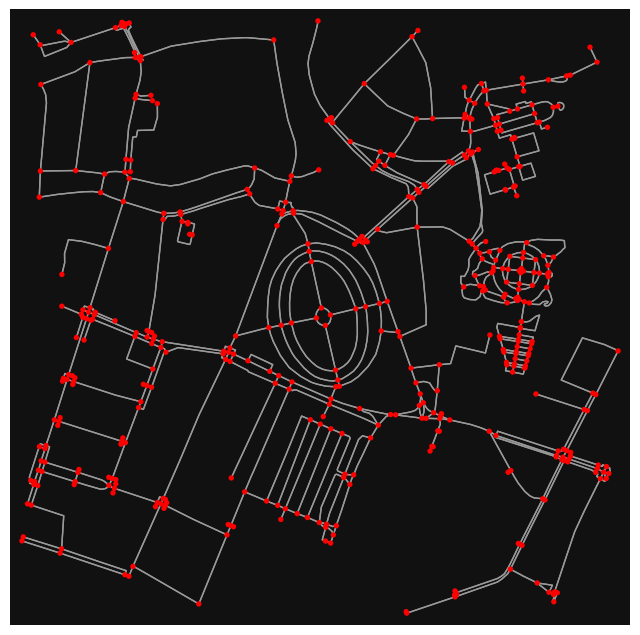

In [6]:
point = 45.39840,11.87644
G_ex = ox.graph_from_point(point, network_type="walk", dist=500)
fig, ax = ox.plot_graph(G_ex, node_color="r")

It is interesting to observe that complex intersections are represented by multiple nodes, which is not what we need.
After consolidating the intersections, the graph becomes:

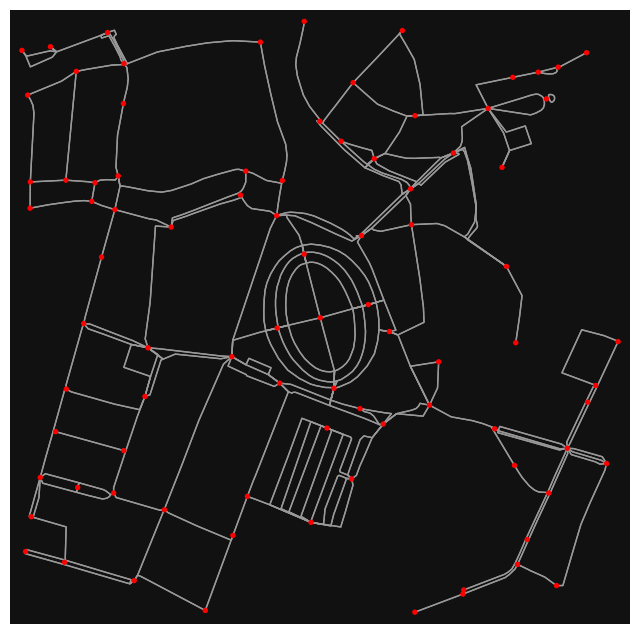

In [7]:
G_proj_ex = ox.project_graph(G_ex)
G_ex_simple = ox.consolidate_intersections(G_proj_ex, rebuild_graph=True, tolerance=15, dead_ends=False)
fig, ax = ox.plot_graph(G_ex_simple, node_color="r")

which conforms much better to modeling.
The drawback is an over-simplification of some connections, like the section at east of Prato della Valle, which is actually the Botanic garden, so simplifying to few nodes is not actually a big deal.
Another example is in the South, where there are a few close parallel connections, but it turns out to be a parking spot, so it is no big deal to over-simplify it.

In [8]:
ox.save_graph_shapefile(G_padova, filepath='data/graph/', encoding='utf-8')

Just to see that everything worked, let's print the GeoDataframes

In [9]:
nodes_gdf = gpd.read_file('data/graph/nodes.shp')
edges_gdf = gpd.read_file('data/graph/edges.shp')

In [10]:
nodes_gdf.head()

,osmid,y,x,highway,street_cou,ref,geometry
0,141540485,45.425355,11.872216,crossing,4,None,POINT (11.87222 45.42536)
1,141542464,45.414087,11.877584,None,3,None,POINT (11.87758 45.41409)
2,141542473,45.413035,11.890344,None,3,None,POINT (11.89034 45.41303)
3,141542517,45.413578,11.879962,None,1,None,POINT (11.87996 45.41358)
4,141542774,45.415890,11.880340,None,3,None,POINT (11.88034 45.41589)


In [11]:
edges_gdf.head(10)

,u,v,key,osmid,highway,oneway,reversed,length,from,to,...,access,junction,width,bridge,tunnel,service,ref,est_width,area,geometry
0,141540485,254672751,0,23516562,path,0,True,5.674,141540485,254672751,...,None,None,None,None,None,None,None,None,None,"LINESTRING (11.87215 45.42534, 11.87222 45.42536)"
1,141540485,197522982,0,41224006,tertiary,0,True,31.809,141540485,197522982,...,None,None,None,None,None,None,None,None,None,"LINESTRING (11.87237 45.42509, 11.87222 45.42536)"
2,141540485,254672878,0,41224006,tertiary,0,False,18.533,141540485,254672878,...,None,None,None,None,None,None,None,None,None,"LINESTRING (11.87214 45.42551, 11.87222 45.42536)"
3,141540485,2522360915,0,244968997,path,0,False,8.132,141540485,2522360915,...,None,None,None,None,None,None,None,None,None,"LINESTRING (11.87231 45.42538, 11.87222 45.42536)"
4,141542464,522059963,0,42046679,residential,0,True,57.846,141542464,522059963,...,None,None,None,None,None,None,None,None,None,"LINESTRING (11.87781 45.41458, 11.87758 45.41409)"
5,141542464,522060005,0,172020585,tertiary,0,False,18.089,141542464,522060005,...,None,None,None,None,None,None,None,None,None,"LINESTRING (11.87736 45.41414, 11.87758 45.41409)"
6,141542464,522060014,0,172020585,tertiary,0,True,72.156,141542464,522060014,...,None,None,None,None,None,None,None,None,None,"LINESTRING (11.87847 45.41390, 11.87796 45.414..."
7,141542473,5792497355,0,204441445,tertiary,0,True,16.896,141542473,5792497355,...,None,None,None,None,None,None,None,None,None,"LINESTRING (11.89054 45.41296, 11.89034 45.41303)"
8,141542473,7086991412,0,224501092,service,0,True,16.168,141542473,7086991412,...,None,None,None,None,None,None,None,None,None,"LINESTRING (11.89044 45.41316, 11.89034 45.41303)"
9,141542473,5798251594,0,204441445,tertiary,0,False,10.330,141542473,5798251594,...,None,None,None,None,None,None,None,None,None,"LINESTRING (11.89023 45.41308, 11.89029 45.413..."


In [12]:
default_crs = str(G_padova.graph["crs"])
default_crs

'epsg:4326'

In [13]:
ox.save_graph_shapefile(G_ex_simple, filepath='data/graph_ex/', encoding='utf-8')
nodes_ex = gpd.read_file('data/graph_ex/nodes.shp')
edges_ex = gpd.read_file('data/graph_ex/edges.shp')

## Point of Interests (POIs)
Let's define the POIs we are interested in, the full table can be found in the presentation paper.

In [14]:
# just for easy scalability
buildings_names = {
    "education": ["school", "kindergarten", "library"],
    "bank": ["bank", "atm"],
    "healthcare": ["clinic", "doctors", "hospital", "pharmacy"],
    "transportation": ["stop_position"],
    "food": ["supermarket","convenience","greengrocer"]
}

For each group, let's create a GeoDataFrame and save it in another dictionary for easy access.

In [15]:
buildings_gdf = dict.fromkeys(buildings_names.keys())
for category in buildings_gdf.keys():
    # set the key (based on OSM specification)
    poi_key = "amenity"
    if category == "transportation":
        poi_key = "public_transport"
    if category == "food":
        poi_key = "shop"

    # set the value (simply the array)
    poi_value = buildings_names[category]

    # create the GeoDataFrame
    buildings_gdf[category] = ox.features_from_place(
            PLACE_NAME,
            {poi_key: poi_value}
        )

    # convert to the same crs as the graph
    buildings_gdf[category] = ox.project_gdf(buildings_gdf[category], to_crs=default_crs)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/releas

In [16]:
for category in buildings_names.keys():
    # create lon and lat columns
    buildings_gdf[category]['geometry'] = buildings_gdf[category]['geometry'].apply(lambda p: p.centroid if p.geom_type == 'Polygon' else p)
    buildings_gdf[category]['lon'] = buildings_gdf[category]['geometry'].apply(lambda p: p.x)
    buildings_gdf[category]['lat'] = buildings_gdf[category]['geometry'].apply(lambda p: p.y)

    # create type column
    buildings_gdf[category]['type'] = category
    
    #select only lon, lat and geometry columns
    buildings_gdf[category] = buildings_gdf[category][['lon', 'lat', 'geometry','type']]
    
    # save to file
    buildings_gdf[category].to_file(f"./data/pois/{category}.gpkg", driver="GPKG")

Building rtree...
Updating external nodes...
Projecting POIs to the network...
Updating internal nodes...
Updating internal edges...
Updating external links...
Remove faulty projections: 1/140 (0.71%)
NOTE: duplication in node coordinates keys
Nodes count: 22696
Node coordinates key count: 21609
Missing 'from' nodes: 0
Missing 'to' nodes: 0
Building rtree...
Updating external nodes...
Projecting POIs to the network...
Updating internal nodes...


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


Updating internal edges...
Updating external links...
Remove faulty projections: 113/113 (100.00%)
NOTE: duplication in node coordinates keys
Nodes count: 22922
Node coordinates key count: 21613
Missing 'from' nodes: 0
Missing 'to' nodes: 0
Building rtree...
Updating external nodes...
Projecting POIs to the network...
Updating internal nodes...
Updating internal edges...
Updating external links...
Remove faulty projections: 95/95 (100.00%)
NOTE: duplication in node coordinates keys
Nodes count: 23112
Node coordinates key count: 21616
Missing 'from' nodes: 0
Missing 'to' nodes: 0
Building rtree...
Updating external nodes...
Projecting POIs to the network...
Updating internal nodes...
Updating internal edges...
Updating external links...
Remove faulty projections: 37/37 (100.00%)
NOTE: duplication in node coordinates keys
Nodes count: 23186
Node coordinates key count: 21574
Missing 'from' nodes: 0
Missing 'to' nodes: 0
Building rtree...
Updating external nodes...
Projecting POIs to the n

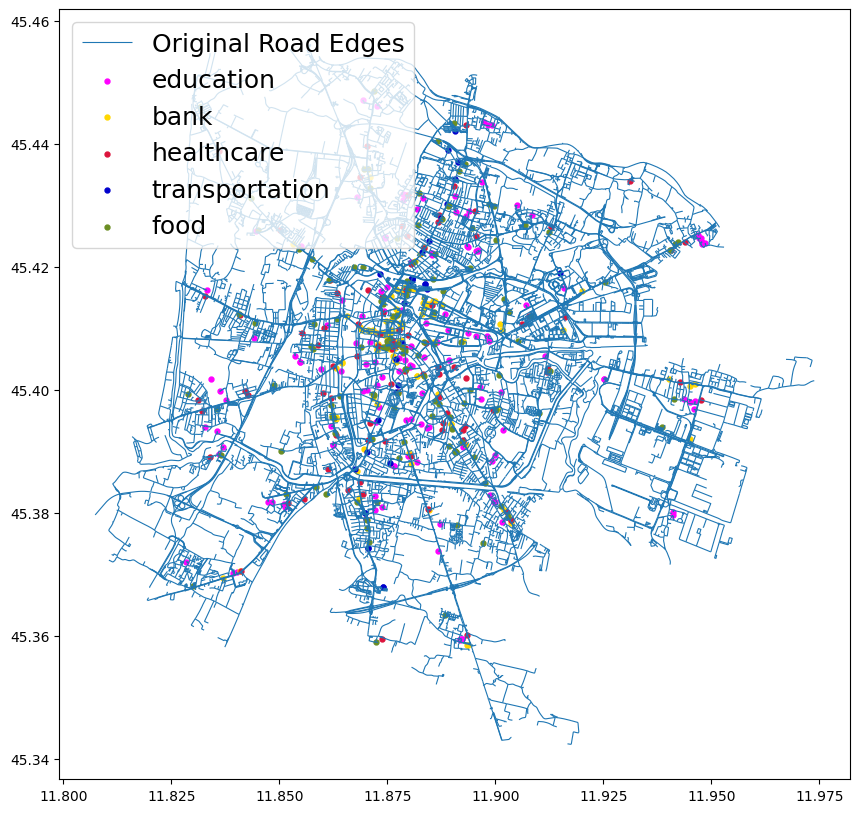

In [19]:
# connect pois
pois_colors = {
    "education": "magenta",
    "bank": "gold",
    "healthcare": "crimson",
    "transportation": "mediumblue",
    "food": "olivedrab"
}

ax = edges_gdf.plot(linewidth=0.8, figsize=(18,10), label='Original Road Edges')

for category in buildings_gdf.keys():
    pois = gpd.read_file(f'./data/pois/{category}.gpkg')
    pois['key'] = 999100000 + pois.index

    nodes_gdf, edges_gdf = connect_poi(pois, nodes_gdf, edges_gdf, key_col='key', path=None)

    pois.plot(color=pois_colors[category], marker='.', markersize=50, ax=ax, label=category)

ax.legend(loc=2, fontsize=18)